<a href="https://colab.research.google.com/github/vedvkandge2000/Deep-Learning-Project/blob/master/MNIST_using_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
mean_gray = 0.1307
stddev_gray = 0.3081

# input[channel] = (input[channel] - mean[channel])/std[channel]

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((mean_gray),(stddev_gray))])

train_dataset = datasets.MNIST(root = "/content/data",
                               train = True,
                               transform = transforms,
                               download=True)

test_dataset = datasets.MNIST(root = "/content/data",
                               train = False,
                               transform = transforms)

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw




Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


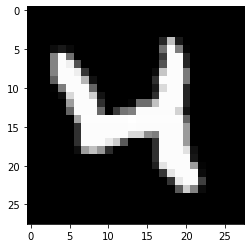

In [ ]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28),cmap= "gray")

In [ ]:
print(train_dataset[20][1])

4


In [ ]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size=100,
                                         shuffle=True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size=100,
                                         shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(train_load))
print(len(test_dataset))
print(len(test_load))

60000
600
10000
100


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    # Same Padding = input_size = output_size
    # Same PAdding = (filter_size-1)/2 --> (3-1)/2 = 1
    self.cnn1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
    # The output size of each 8 features is:
    # [(input_size - filter_size + 2(padding))/stride + 1] --> 28
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.cnn2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5,stride=1,padding=2) # same padding
    # output_size of each 32 feature maps are: [14-5 + 2 * 2]/1 + 1 = 14
    self.batchnorm2 = nn.BatchNorm2d(32)
    # Flatten 32 feature maps 32*7*7 = 1568
    self.fc1 = nn.Linear(1568,600)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(600,10)

  def forward(self,x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    # faltten 32 feature maps from maxpool to feed it to fc1(100,1568)
    out = out.view(-1,1568)
    # we move forward to our fully connected layer
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out

In [ ]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#Understand what's happening
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate (train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted = torch.max(output, 1)
    print("Predicted Shape",predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([1, 8, 1, 1, 1, 3, 1, 6, 2, 7, 1, 1, 2, 7, 1, 3, 8, 4, 1, 6, 1, 6, 6, 1,
        1, 1, 1, 6, 7, 1, 1, 7, 5, 7, 6, 5, 1, 3, 5, 4, 2, 6, 2, 1, 6, 1, 5, 1,
        1, 1, 6, 2, 2, 3, 6, 7, 1, 1, 1, 1, 6, 7, 1, 1, 1, 7, 6, 2, 2, 6, 6, 1,
        1, 6, 1, 1, 7, 6, 1, 1, 5, 1, 1, 1, 7, 1, 1, 6, 1, 8, 6, 6, 5, 3, 6, 2,
        1, 1, 1, 6], device='cuda:0')


In [ ]:
# Training the CNN
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()  # We have specify that currently we are training the model because we have added dropout and batchnormalization 

  for i, (inputs,labels) in enumerate(train_load):

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()
    
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    iter_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum().item()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append(100 * correct / len(train_dataset))

  # test phase
  testing_loss = 0.0
  correct = 0
  iterations = 0 

  model.eval()

  for i, (inputs,labels) in enumerate(test_load):

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()
    
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    testing_loss += loss.item()

    _,predicted = torch.max(outputs,1)
    correct += (predicted == labels).sum().item()
    iterations += 1

  test_loss.append(testing_loss/iterations)
  test_accuracy.append(100 * correct / len(test_dataset))

  print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(
      epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]
  ))

Epoch 1/10, Training Loss: 0.116, Training Accuracy: 96.578, Testing Loss: 0.043, Testing Accuracy: 98.700
Epoch 2/10, Training Loss: 0.094, Training Accuracy: 97.317, Testing Loss: 0.048, Testing Accuracy: 98.660
Epoch 3/10, Training Loss: 0.079, Training Accuracy: 97.785, Testing Loss: 0.041, Testing Accuracy: 98.790
Epoch 4/10, Training Loss: 0.069, Training Accuracy: 98.042, Testing Loss: 0.047, Testing Accuracy: 98.610
Epoch 5/10, Training Loss: 0.068, Training Accuracy: 98.057, Testing Loss: 0.043, Testing Accuracy: 98.840
Epoch 6/10, Training Loss: 0.065, Training Accuracy: 98.208, Testing Loss: 0.039, Testing Accuracy: 98.920
Epoch 7/10, Training Loss: 0.056, Training Accuracy: 98.388, Testing Loss: 0.044, Testing Accuracy: 98.870
Epoch 8/10, Training Loss: 0.057, Training Accuracy: 98.345, Testing Loss: 0.041, Testing Accuracy: 98.870
Epoch 9/10, Training Loss: 0.055, Training Accuracy: 98.373, Testing Loss: 0.046, Testing Accuracy: 98.730
Epoch 10/10, Training Loss: 0.050, Tr

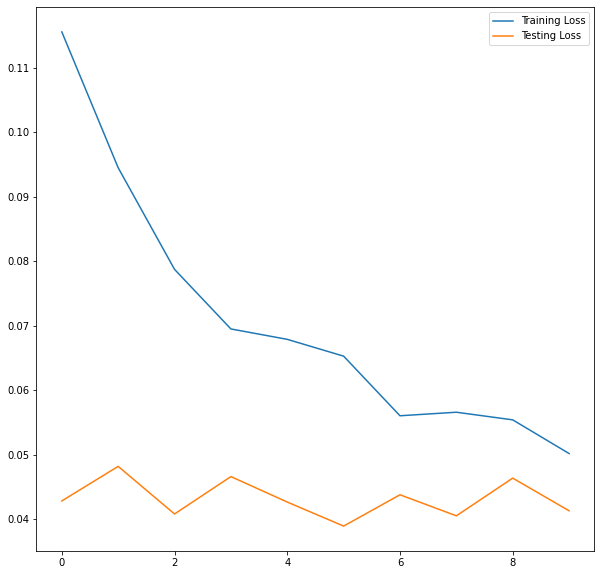

In [ ]:
# Plotting loss

f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label= "Training Loss")
plt.plot(test_loss, label= "Testing Loss")
plt.legend()
plt.show()

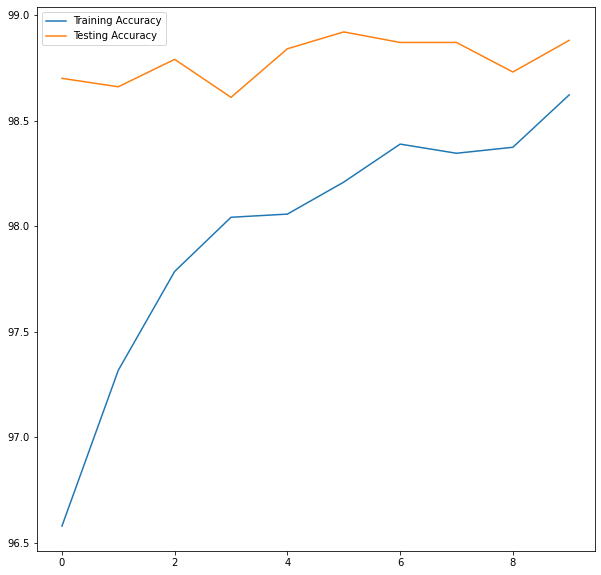

In [ ]:
# Plotting Accuracy

f = plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label= "Training Accuracy")
plt.plot(test_accuracy, label= "Testing Accuracy")
plt.legend()
plt.show()

In [ ]:
img = test_dataset[6][0].resize_((1,1,28,28))
label = test_dataset[6][1]

model.eval()

if CUDA:
  model = model.cuda()
  img = img.cuda()

outputs = model(img)
_,predicted = torch.max(outputs,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 4
Actual is: 4
